Привет! меня зовут Люман Аблаев. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>


<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление</font>
* Спасибо за интересный проект - было приятно его проверять.
* Отличная работа с кодом и с моделями машинного обучения.
- Я оставил некоторые советы, обрати на них внимание, они могут сделать работу лучше и быть полезными или интересными.
- Есть некоторые недочеты, которые нужно поправить и обновить немного работу
- Давай еще разок

<font color='orange' style='font-size:24px; font-weight:bold'>Общее впечатление[2]</font>
* Спасибо за оперативность
- Недочеты исправлены - работа полностью корректна
- Рад был быть полезен. Удачи в дальнейшем обучении!

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
from collections import namedtuple

import time

RANDOM_STATE = 131296

<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты на месте

In [2]:
#создадим кортеж для дальнейшего использования со следующей информацией - время фиттинга, время предсказания и RMSE
ModelTimeAndRMSE = namedtuple('ModelTimeAndRMSE', ('fit_time', 'predict_time', 'rmse'))

In [3]:
#создадим функцию для первичного анализа
def first_analyze(data):
    rows, columns = data.shape
    print('='*50)
    print('Количество строк:', rows)
    print('Количество столбцов:', columns)
    display(data.head())
    display(data.describe())
    print(data.info())
    print('='*50)

In [4]:
#создадим функцию для печати количества пропусков по столбцам
def print_nan_percent(data):
    print('Пропуски')
    nan_columns = []
    
    for column in data.columns:
        nan_columns.append({
            'column': column, 
            'nan_count': data[column].isnull().sum(),
            'nan_percent': 100 * data[column].isnull().sum() / data.shape[0],
        })
    
    display(pd.DataFrame(nan_columns))

In [5]:
#создадим функцию для построения гистограм по определённому столбцу из датафрейма
def plot_hist(data, column, bins=100): 
    data[column].plot(kind='hist',
                      bins=bins, 
                      title=column,
                      grid=True,
                      figsize=(10,5),
                     )

In [6]:
#создадим функцию для печати количество нулевых значений в столбце
def print_zero_percent_in_column(data, column):
    zero_count = data[data[column] == 0].shape[0]
    print('Нулевых значений в {}: {}'.format(column, zero_count))
    print('% нулевых значений в {}: {:.2%}'.format(column, zero_count / data.shape[0]))

In [48]:
def get_model_time_and_rmse(model): #для кросс-валидации
    #fit_start = time.time()
    #model.fit(features_train, target_train)
    #fit_time = time.time() - fit_start
    
    fit_time = model.cv_results_['mean_fit_time'][model.best_index_]
    predict_time = model.cv_results_['mean_score_time'][model.best_index_]
    rmse = (-model.best_score_)**0.5
    
    return ModelTimeAndRMSE(fit_time, predict_time, rmse)

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Времена выполнения и предикта и результат MSE взяты из результатов GridSearchCV
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Отличный выбор!
</div>


<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошие помощники

### Первичный анализ данных

Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак
* Price — цена (евро)

In [9]:
auto_data = pd.read_csv('/datasets/autos.csv')

In [10]:
first_analyze(auto_data)

Количество строк: 354369
Количество столбцов: 16


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Пропуски присутствуют в столбцах:
* VehicleType
* Gearbox
* Model
* FuelType
* Repaired

Есть столбцы, применение которых в качестве признаков не имеет смысла:
* DateCrawled
* DateCreated
* NumberOfPictures
* PostalCode
* LastSeen

В некоторых столбцах присутствуют аномальные значения:
* Price
* RegistrationYear
* Power
* RegistrationMonth

<div class="alert alert-block alert-info">
<b>Совет </b>  Советую обратить внимание на библиотеки sweetviz и pandas_profiling помогут в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки хороши для максимизации комфорта презентации результатов анализа бизнес-пользователям. 
    
Очень просты в использоовании, на вход кладется датафрейм: pandas_profiling.ProfileReport(df) 
    
    
    
</div>

###  Удаление лишних признаков

Удалим столбцы DateCrawled, DateCreated, NumberOfPictures, PostalCode и LastSeen.

In [11]:
auto_data = auto_data.drop(columns = ['DateCrawled',
                                      'DateCreated',
                                      'NumberOfPictures',
                                      'PostalCode',
                                      'LastSeen'])

<div class="alert alert-block alert-success">
<b>Успех:</b> Удалить неинформативные признаки - хорошее решение

### Заполнение пропусков

Перед заполнением пропусков оценим их количество

In [12]:
print_nan_percent(auto_data)

Пропуски


,column,nan_count,nan_percent
0,Price,0,0.000000
1,VehicleType,37490,10.579368
2,RegistrationYear,0,0.000000
3,Gearbox,19833,5.596709
4,Power,0,0.000000
5,Model,19705,5.560588
6,Kilometer,0,0.000000
7,RegistrationMonth,0,0.000000
8,FuelType,32895,9.282697
9,Brand,0,0.000000


В разных столбцах от 5 до 20 процентов пропусков. Все столбцы с пропусками - категориальные. Чтобы не терять эти записи полностью - заполним пропуски новым категориальным значением 'unknown'.

In [13]:
auto_data = auto_data.fillna('unknown')

<div class="alert alert-block alert-success">
<b>Успех:</b> Хороший способ

Убедимся в отсутствии пропусков после их заполнения.

In [14]:
print_nan_percent(auto_data)

Пропуски


,column,nan_count,nan_percent
0,Price,0,0.0
1,VehicleType,0,0.0
2,RegistrationYear,0,0.0
3,Gearbox,0,0.0
4,Power,0,0.0
5,Model,0,0.0
6,Kilometer,0,0.0
7,RegistrationMonth,0,0.0
8,FuelType,0,0.0
9,Brand,0,0.0


### Обработка аномальных значений

Выбросы были в следующих столбцах - Price, RegistrationYear, Power и RegistrationMonth. Пойдём по порядку.

#### Price

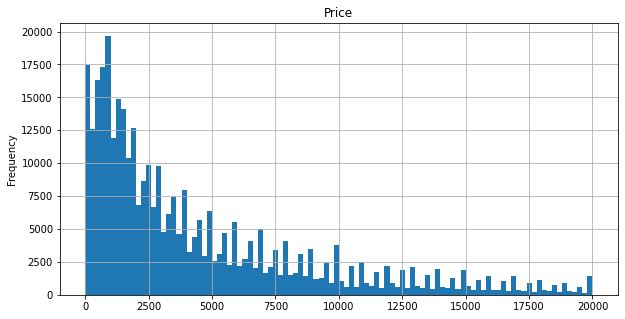

In [15]:
plot_hist(auto_data, 'Price')

Есть много нулевых значений - посмотрим сколько их и удалим. Максимальное значение - 20 тысяч евро - это вполне вероятная цена для автомобиля.

In [16]:
print_zero_percent_in_column(auto_data, 'Price')

Нулевых значений в Price: 10772
% нулевых значений в Price: 3.04%


In [17]:
auto_data = auto_data.query('Price > 0')


<div class="alert alert-block alert-info">
<b>Совет:</b>  А около-нулевые цены, не кажется подозрительными? Самое интересное, что на нескольких сайтов по продажам подержанных автомобилей в Германии (страну можно определить по почтовым индексам, большинство из них из Германии) показало, что цены начинаются действительно с 0 и 1 евро, но это единичные объявления и не понятно, то ли это ошибка при заполнении формы, то ли машины на металлолом. Но я  все-таки склоняюсь к тому, чтобы избавиться от таких данных
    


    
</div>


#### RegistrationYear

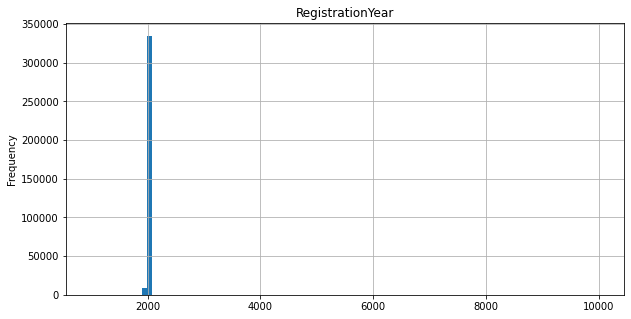

In [18]:
plot_hist(auto_data, 'RegistrationYear')

График не информативен, воспользуемся логикой - в качестве левой границы возьмём год начала производства первого серийного автомобиля - 1888 (Benz Patent-Motorwagen, вдруг такой раритет есть в продаже); в качестве правой границы возьмём год на момент выполнения проекта - 2022.

In [19]:
auto_data_reg_year_anom = auto_data.query('RegistrationYear < 1888 | RegistrationYear > 2022')
print('Удалим все авто с годом регистрации меньше 1886 или больше 2020, их всего: {}'
      .format(auto_data_reg_year_anom.shape[0]))
print('В процентном соотношении: {:.2%}'
      .format(auto_data_reg_year_anom.shape[0] / auto_data.shape[0]))
auto_data.drop(auto_data_reg_year_anom.index, axis=0, inplace=True)

Удалим все авто с годом регистрации меньше 1886 или больше 2020, их всего: 139
В процентном соотношении: 0.04%


<div class="alert alert-block alert-info">
    
<b>Совет:</b> Также советую посмотреть на дату выгрузки базы - там тоже можно увидеть полезную информацию
</div>

#### Power

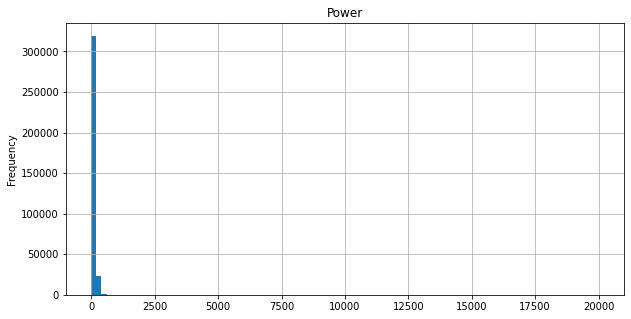

In [20]:
plot_hist(auto_data, 'Power')

График не информативен. Посмотрим 0.99 квантиль.

In [21]:
print(auto_data['Power'].quantile(0.999))

603.0


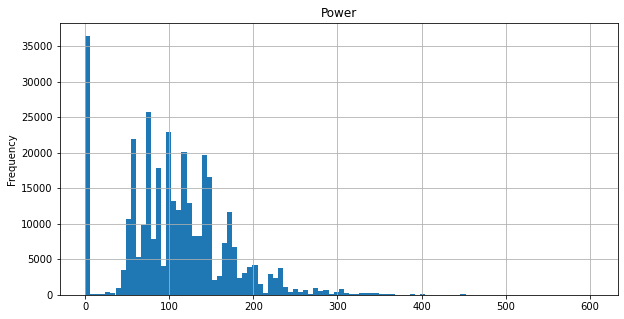

In [22]:
plot_hist(auto_data.query('Power <= 603'), 'Power')

Очень много нулей - узнаем сколько их.

In [23]:
print_zero_percent_in_column(auto_data, 'Power')

Нулевых значений в Power: 36259
% нулевых значений в Power: 10.56%


Возьмём все значения больше 0 и меньше 2012 л.с. - мощность самого мощного серийного автомобиля [Aspark Owl](https://rating-avto.ru/cars/reyting-samyih-moschnyih-v-mire-avtomobiley.html) на 2022 год.

In [24]:
auto_data_pwr_anom = auto_data.query('Power == 0 | Power > 2012')
print('Удалим все авто с мощностью двигателя равной 0 или больше 2012, их всего: {}'
      .format(auto_data_pwr_anom.shape[0]))
print('В процентном соотношении: {:.2%}'
      .format(auto_data_pwr_anom.shape[0] / auto_data.shape[0]))
auto_data.drop(auto_data_pwr_anom.index, axis=0, inplace=True)

Удалим все авто с мощностью двигателя равной 0 или больше 2012, их всего: 36367
В процентном соотношении: 10.59%



<div class="alert alert-block alert-info">
<b>Совет:</b>  Как думаешь а машины с 0-ой мощностью могут быть просто без двигателя?
</div>


#### RegistrationMonth

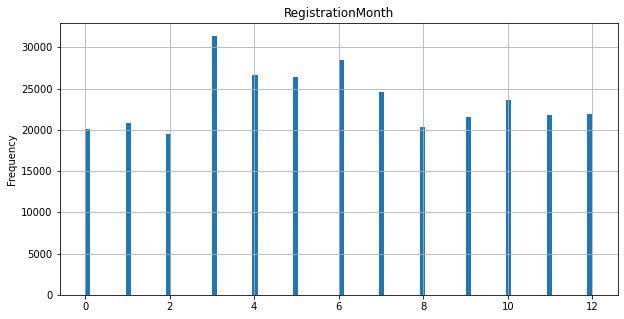

In [25]:
plot_hist(auto_data, 'RegistrationMonth')

Данные разделены на номера месяцов с 0 до 12 - всего выходит 13 месяцев. Однако в году всего 12 месяцев. Так как это не индекси месяца, а номер месяца по условию - месяц номер 0 является лишним.

Для упращения будем считать, что месяц 0 = месяц неизвестен.

### Повторный анализ данных

In [26]:
first_analyze(auto_data)

Количество строк: 307091
Количество столбцов: 11


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,307091.000000,307091.000000,307091.000000,307091.000000,307091.000000
mean,4810.307668,2003.299058,121.113934,128419.426164,5.963389
std,4586.673732,6.954421,63.831722,36744.571553,3.600223
min,1.000000,1910.000000,1.000000,5000.000000,0.000000
25%,1300.000000,1999.000000,75.000000,125000.000000,3.000000
50%,3100.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6950.000000,2008.000000,150.000000,150000.000000,9.000000
max,20000.000000,2019.000000,2009.000000,150000.000000,12.000000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 307091 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              307091 non-null  int64 
 1   VehicleType        307091 non-null  object
 2   RegistrationYear   307091 non-null  int64 
 3   Gearbox            307091 non-null  object
 4   Power              307091 non-null  int64 
 5   Model              307091 non-null  object
 6   Kilometer          307091 non-null  int64 
 7   RegistrationMonth  307091 non-null  int64 
 8   FuelType           307091 non-null  object
 9   Brand              307091 non-null  object
 10  Repaired           307091 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.1+ MB
None


Пропусков нет, явные аномальные значения удалены.

<div class="alert alert-block alert-success">
<b>Успех:</b> В целом неплохая, детальная предобработка - идем дальше

## Обучение моделей

Выделим названия категориальных признаков в список.

In [27]:
cat_features = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model',
                'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

Выделим целевой признак - цену.

In [28]:
features = auto_data.drop(columns=['Price'])
target = auto_data['Price']

Так как мы будем использовать GridSearchCV нам не требуется валидационная выборка. Отдельной скрытой тестовой выборки не предоставленно - будем делать данные на две выборки - тренировочную для кросс-валидации (CV) и тестовую (test). 

In [29]:
features_cv, features_test, target_cv, target_test = train_test_split(features,
                                                                      target,
                                                                      test_size=0.25,
                                                                      shuffle=True,
                                                                      random_state=RANDOM_STATE)

Для дальнейшего анализа результатов создадим пустой список для результатов моделей.

In [30]:
models_stats = []

### CatBoost

In [31]:
model = CatBoostRegressor(random_seed=RANDOM_STATE, loss_function='RMSE', silent=True, cat_features=cat_features)

param_grid = {'learning_rate': [0.1, 0.01],
              'depth': [6, 8, 10],
              'iterations': [40, 60]
             }

search_cb = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=False)

In [32]:
%%time
search_cb.fit(features_cv, target_cv)

CPU times: user 5min 26s, sys: 2.62 s, total: 5min 29s
Wall time: 5min 57s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f2c487862b0>,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': [0.1, 0.01]},
             scoring='neg_mean_squared_error', verbose=False)

Сохраним статистику для этой модели.

In [34]:
stats = get_model_time_and_rmse(search_cb)

models_stats.append({'model': 'CatBoost',
                     'fit_time': stats.fit_time,
                     'predict_time': stats.predict_time,
                     'RMSE': stats.rmse
                    })

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Тут и в остальных моделях в качестве аргументов теперь передаётся только результат GridSearchCV
</div>

<div class="alert alert-block alert-success">
<b>Успех:</b> Радует, что был применен внутренний метод кодировки данных

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Использование тестовой выборки до шага с тестированием не должно быть, время предсказания можно считать тремя способами:
    
- на валидационной
- на тренировочной
- В твоем случае, мне кажется лучше всего вытаскивать эти значения из GridSearchCV, все они лежат в `.cv_results_`
    
Отмечу, что если ты будешь замерять время предсказания на тренировочной, то качество полученное на тренировочное - для анализа не подходит, придется качество отдельно замерить с помощью какого-нибудь cross_val_score.
</div>


<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Недочет исправлен
</div>


### LightGBM

Создадим копию признаков для LightGBM и установим для категориальных прищнаков тип данных 'category'.

In [36]:
features_cv_lgbm = features_cv.copy()
features_test_lgbm = features_test.copy()

for df in [features_cv_lgbm, features_test_lgbm]: 
    df[cat_features] = df[cat_features].astype('category')

<div class="alert alert-block alert-success">
<b>Успех:</b> И здесь внутренний метод кодировки данных применен успешно

In [37]:
model = LGBMRegressor(random_seed=RANDOM_STATE)

param_grid = {'learning_rate': [0.01, 0.1],
              'max_depth':[6, 8, 10],
              'n_estimators': [60, 80, 100]
             }

search_lgbm = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose= False)

In [38]:
%%time
search_lgbm.fit(features_cv_lgbm, target_cv)

CPU times: user 14min 9s, sys: 7.8 s, total: 14min 17s
Wall time: 14min 26s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_seed=131296),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 8, 10],
                         'n_estimators': [60, 80, 100]},
             scoring='neg_mean_squared_error', verbose=False)

Сохраним статистику для этой модели.

In [39]:
stats = get_model_time_and_rmse(search_lgbm)

models_stats.append({'model': 'LightGBM',
                     'fit_time': stats.fit_time,
                     'predict_time': stats.predict_time,
                     'RMSE': stats.rmse
                    })

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> То же самое в тестовой выборкой

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть
</div>


### Ridge

Для сравнения построиме Ridge модель - однако, для неё необходимо использовать какое либо преобразование категориальных данных. Для этого будем использовать пайплайн с OHE.

In [40]:
pipeline = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')),
                     ('model', Ridge(random_state=RANDOM_STATE))
                    ])

param_grid = {'model__alpha': [20, 10, 5, 1, 0.1, 0.01, 0.001, 0]}

search_ridge = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=False)

<div class="alert alert-block alert-success">
<b>Успех:</b> OHE - хороший выбор, применен корректно, лайк за продвинутый инструмент pipeline.

In [41]:
%%time
search_ridge.fit(features_cv, target_cv)

CPU times: user 42.5 s, sys: 1.16 s, total: 43.7 s
Wall time: 43.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ohe',
                                        OneHotEncoder(handle_unknown='ignore')),
                                       ('model', Ridge(random_state=131296))]),
             param_grid={'model__alpha': [20, 10, 5, 1, 0.1, 0.01, 0.001, 0]},
             scoring='neg_mean_squared_error', verbose=False)

Сохраним статистику для этой модели.

In [42]:
stats = get_model_time_and_rmse(search_ridge)

models_stats.append({'model': 'Ridge',
                     'fit_time': stats.fit_time,
                     'predict_time': stats.predict_time,
                     'RMSE': stats.rmse
                    })

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Тестовая выборка =)

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть
</div>


## Анализ моделей

Посмотрим на таблицу с данными испытанных моделей и сделаем соответствующие выводы.

In [43]:
display(pd.DataFrame(models_stats))

,model,fit_time,predict_time,RMSE
0,CatBoost,8.178418,0.077612,1754.651177
1,LightGBM,4.577308,0.484430,1642.095272
2,Ridge,1.047610,0.078519,2018.133782


По данным моделей можно сделать следующие выводы:
* качество моделей градиентного бустинга схоже друг с другом, лучший результат LightGBM можно объяснить более удачными гиперпараметрами;
* время обучения CatBoost в 1.8 раз больше, чем у LightGBM;
* время предсказаний CatBoost в 6 раз меньше, чем у LightGBM;
* линейная модель Ridge обучается и предсказывает быстрее, чем модели градиентного бустнига, однако её качество заметно хуже;

По результатам работы моделей можно сделать вывод, что модели градиентного бустинга в условиях большого количества категориальных значений работают лучше, чем линейные модели.

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Изменены выводы в соответствии с новыми данными.
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Есть контакт. Всегда приятно наблюдать подробный и структурированный вывод в конце работы!
</div>


Так как модель LightGBM показала результат лучше, чем CatBoost, при этом суммарное время обучения и предсказания у модели LightGBM на 3.2 секунды меньше, чем у CatBoost - для испытания на тестовой выборке будем использовать именно эту модель.

In [47]:
predictions = search_lgbm.predict(features_test_lgbm)
rmse = mean_squared_error(target_test, predictions) ** 0.5
print('RMSE модели LightGBM на тестовой выборке:', rmse)

RMSE модели LightGBM на тестовой выборке: 1634.0561807876907


Качество модели LightGBM на тестовой выборке меньше 2500 - модель удовлетворяет требованию по качеству.

<div class="alert alert-block alert-success">
<b>Успех:</b> Шаг проделан замечательно, все нужные метрики считаются, радует наиличие кросс-валидационных методов для подбора гиперпараметров и использование внутренних методов кодировки данных.

<div class="alert alert-block alert-danger">
    
<b>Ошибка:</b> К этому моменту мы получаем все метрики для наших моделей (без использования тестовой выборки) - проводим анализ, выбираем наилучшую модель. И дальше тестируем ОДНУ наилучшую модель =)
  
</div>

<div class="alert alert-block alert-success">
<b>Успех[2]:</b> Получено хорошее качество на тесте!
</div>




<div class="alert alert-block alert-info">
<b>Совет:</b> 

Также если говорить, что можно ещё улучшить в подобных проектах, то я бы выделил такие моменты:<br>
    
1) Для понимания, а какие в итоге факторы важны при моделировании, можно выводить их важность, использую feature_importances_, ну и график заодно. Это будет смотреться очнь здорово: результативная метрика и график важности факторов))) 

2) У нас разный возраст машин. Есть гипотеза, что для разных возрастов - своё ценообразование. Поэтому, можно попробовать ввести фактор "тип возраста" (ретро, супер-ретро, старая, новая... надо подумать..)..<br>


</div>


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей